In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [3]:
import os
import glob
from typing import NamedTuple

In [4]:
glob.glob(os.path.join('..', 'measurements', 'logic', '24 MHz', '*.csv'))

['../measurements/logic/24 MHz/Both in sight, obstructed (24 MHz, 240 M Samples).csv',
 '../measurements/logic/24 MHz/Only B enabled (24 MHz, 240 M Samples).csv',
 '../measurements/logic/24 MHz/Only C in sight (24 MHz, 240 M Samples).csv',
 '../measurements/logic/24 MHz/Both in sight (24 MHz, 240 M Samples).csv',
 '../measurements/logic/24 MHz/Only B in sight (24 MHz, 240 M Samples).csv']

For the given data sequences, the sensor diode was placed **about 2 m** away from Lighthouse A (measured directly), roughly **1.4 m** to the left (when looking straight at it), as well as **1.5 m** beneath it. Depending on the direction of the sweep, this places the diode either relatively close to the beginning or the end of it.

Likewise, the diode was placed about **1.5 m** to the right of Lighthouse B (when looking straight at it), as well as about **1.7 m** beneath it, and at a distance of 3.5 m (totaling about **4.2 m**).

In [5]:
csv_files = glob.glob(os.path.join('..', 'measurements', 'logic', '24 MHz', 'Both*.csv'))
csv_files

['../measurements/logic/24 MHz/Both in sight, obstructed (24 MHz, 240 M Samples).csv',
 '../measurements/logic/24 MHz/Both in sight (24 MHz, 240 M Samples).csv']

In [6]:
df_src = pd.read_csv(csv_files[1], names=['Time [s]', 'Level'], skiprows=1)
df_src.dtypes

Time [s]    float64
Level         int64
dtype: object

In [7]:
df_src.describe()

,Time [s],Level
count,7143.000000,7143.000000
mean,4.972771,0.499930
std,2.880369,0.500035
min,-0.005241,0.000000
25%,2.480376,0.000000
50%,4.961085,0.000000
75%,7.459203,1.000000
max,9.994849,1.000000


In [8]:
df_src.head(n=8)

,Time [s],Level
0,-0.005241,0
1,0.000000,1
2,0.000075,0
3,0.000419,1
4,0.000530,0
5,0.003090,1
6,0.003104,0
7,0.008333,1


Let's visualize the pulses to see whether the data makes sense at a first glance.

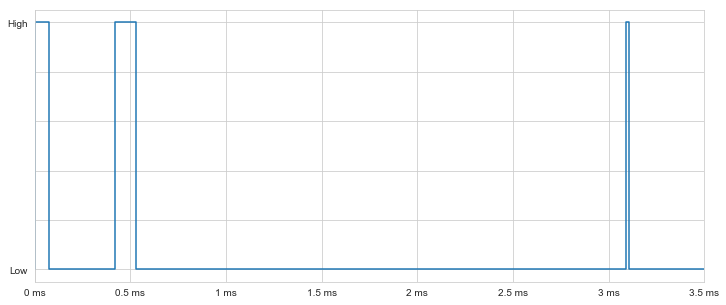

In [9]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.step(x=df_src['Time [s]'], y=df_src['Level'], where='post');
ax.set_xlim([0, 0.0035]);
ax.set_xticklabels(['0 ms', '0.5 ms', '1 ms', '1.5 ms', '2 ms', '2.5 ms', '3 ms', '3.5 ms']);
ax.set_yticklabels(['', 'Low', '', '', '', '', 'High']);

That seems to be fine. Let's look at a longer sequence.

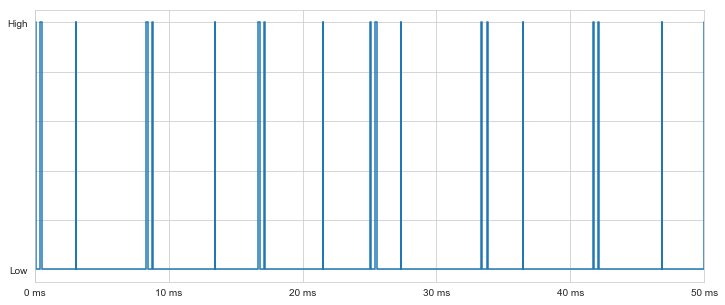

In [10]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.step(x=df_src['Time [s]'], y=df_src['Level'], where='post');
ax.set_xlim([0, 0.05])
ax.set_xticklabels(['0 ms', '10 ms', '20 ms', '30 ms', '40 ms', '50 ms'])
ax.set_yticklabels(['', 'Low', '', '', '', '', 'High']);

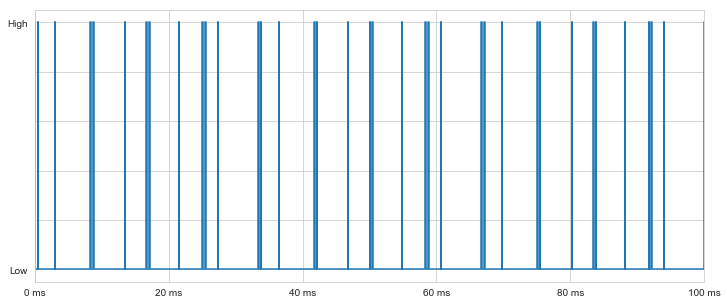

In [11]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.step(x=df_src['Time [s]'], y=df_src['Level'], where='post');
ax.set_xlim([0, 0.1])
ax.set_xticklabels(['0 ms', '20 ms', '40 ms', '60 ms', '80 ms', '100 ms'])
ax.set_yticklabels(['', 'Low', '', '', '', '', 'High']);

Next, we determine the durations of the high and low states by taking the piecewise difference to the next state.

In [12]:
df_durations = (df_src.shift(-1)['Time [s]'] - df_src['Time [s]']).to_frame(name='Duration [s]')
df = df_src.join(df_durations)
df.head(10)

,Time [s],Level,Duration [s]
0,-0.005241,0,0.005241
1,0.000000,1,0.000075
2,0.000075,0,0.000344
3,0.000419,1,0.000111
4,0.000530,0,0.002561
5,0.003090,1,0.000014
6,0.003104,0,0.005228
7,0.008333,1,0.000107
8,0.008439,0,0.000313
9,0.008752,1,0.000059


For further insights, we're going to isolate the High pulses and convert them to microseconds.

In [13]:
def sec_to_us(t: float) -> float:
    return t * 1_000_000

In [14]:
def us_to_sec(t: float) -> float:
    return t / 1_000_000

In [15]:
df_high_filter = df['Level'] > 0
df_high_durations = df.loc[df_high_filter, 'Duration [s]']
df_high_durations_us = sec_to_us(df_high_durations).to_frame(name='Duration [µs]').dropna()

The statistics give that the pulse duration ranges from 0.625 µs to about 137.792 µs:

In [16]:
df_high_durations_us.describe()

,Duration [µs]
count,3571.000000
mean,66.567266
std,46.740835
min,0.458333
25%,14.083333
50%,74.833333
75%,106.583333
max,137.875000


Given the lower and upper boundary for the pulse durations, we can now inspect the histogram.

The dotted magenta lines show the positions of the defined OOTX (Omnidirectional Optical Transmitter) sync pulse lengths at

- 62.5 µs, 
- 72.9 µs, 
- 83.3 µs, 
- 93.8 µs,
- 104 µs,
- 115 µs,
- 125 µs and
- 135 µs.

We can see that the histogram peaks are offset from these expected locations quite noticeably. The dash-dotted magenta line indicates the lower bound for peaks, as described later.

In [17]:
sync_peak_end = np.array([62.5, 72.9, 83.3, 93.8, 104, 115, 125, 135])

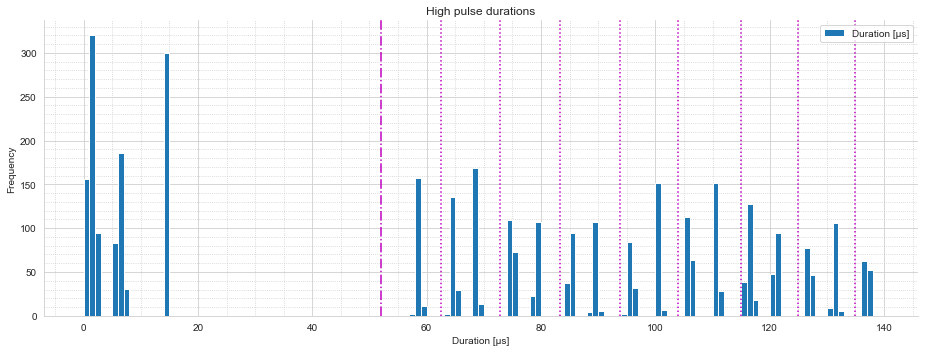

In [18]:
fig, ax = plt.subplots(figsize=(13, 5))
df_high_durations_us.plot.hist(bins=np.arange(0, 140, 1), ax=ax);
for x in sync_peak_end:
    ax.axvline(x, 0, 300, color='m', linestyle=':')
ax.axvline(52, 0, 300, color='m', linestyle='-.')
ax.set_xlabel('Duration [µs]')
ax.set_title('High pulse durations')
ax.grid(b=True, which='minor', linestyle=':')
ax.minorticks_on()
sns.despine()
fig.tight_layout();

We also see a high number of pulses at about 7 … 8 µs and 13 … 14 µs. We can expect these to be the laser sweeps.

Pulse length durations as described [here](https://github.com/widemeadows/LighthouseRedox/blob/master/docs/Light%20Emissions.md):

> Name | skip | data | axis  | length (ticks) | length (µs)
> -----|------|------|-------|----------------|------------
> j0   | 0    | 0    | 0     | 3000           | 62.5
> k0   | 0    | 0    | 1     | 3500           | 72.9
> j1   | 0    | 1    | 0     | 4000           | 83.3
> k1   | 0    | 1    | 1     | 4500           | 93.8
> j2   | 1    | 0    | 0     | 5000           | 104
> k2   | 1    | 0    | 1     | 5500           | 115
> j3   | 1    | 1    | 0     | 6000           | 125
> k3   | 1    | 1    | 1     | 6500           | 135
> 
> Each length represents a combination of 3 bit states:
>
> - The **axis** bit determines the rotation axis for the laser sweep that follows the sync pulse.
> - The **skip** bit determines if the rotor will skip this period and leave its laser off.
> - The **data** bits of consecutive sync pulses of a base station concatenated together yield a data structure called OOTX Frame.
>
> In reality the listed sync pulse lengths should be considered maximum values. The real length should be in a 500 tick window ending at the listed length.
> E.g. sync pulse _j0_ can be 2501-3000 ticks long depending on the position and orientation relative to the base station.
>
> Given a measured pulse length the best match can be found using:
>
> `[skip,data,axis] = (length - 2501) / 500`
>
> Given the 3 bits the pulse length can be calculated:
>
> `length = 3000 + axis*500 + data*1000 + skip*2000`

From the above table, we find that each "tick" represents about 0.0208 µs, or 20.83 ns:

In [19]:
tick_us = (sync_peak_end / np.array(range(3000, 7000, 500))).mean()
tick_us

0.020830375527250526

This duration resembles about 48 MHz, which has a period length of $20.8\bar 3 \,s$.

In [20]:
1/us_to_sec(tick_us)

48006815.7528792

What we know is that 48 MHz is related to USB and the numbers align nicely for the above equations. For a microcontroller running at 72 MHz, we'd use tick values in multiples of 750 instead:

In [21]:
print(np.array(range(3000, 7000, 500)) / 48_000_000 * 72_000_000, '\n',
      500 / 48_000_000 * 72_000_000)

[4500. 5250. 6000. 6750. 7500. 8250. 9000. 9750.] 
 750.0


As for the skew, we allow for a window of 500 ticks at 48 MHz, or about 10.42 µs:

In [22]:
sec_to_us(500 / 48_000_000)

10.416666666666666

Across all values, however, a skew of 10 µs seems to be safer:

In [23]:
np.diff(sync_peak_end)

array([10.4, 10.4, 10.5, 10.2, 11. , 10. , 10. ])

In [24]:
np.sqrt(1.4**2 + 1.5**2), np.sqrt((1.5**2 + 1.7**2) + 3.5**2)

(2.0518284528683193, 4.170131892398609)

In [25]:
OOTXPulse = NamedTuple('OOTXPulse', [('valid', bool), ('name', str), 
                                     ('skip', bool), ('data', int), ('axis', int)])

invalid_pulse = OOTXPulse(valid=False, name='None', skip=False, data=0, axis=0)

ootx_pulses = [
    OOTXPulse(valid=True, name='j-0', skip=False, data=0, axis=0),
    OOTXPulse(valid=True, name='k-0', skip=False, data=0, axis=1),
    OOTXPulse(valid=True, name='j-1', skip=False, data=1, axis=0),
    OOTXPulse(valid=True, name='k-1', skip=False, data=1, axis=1),
    OOTXPulse(valid=True, name='j-2', skip=True, data=0, axis=0),
    OOTXPulse(valid=True, name='k-2', skip=True, data=0, axis=1),
    OOTXPulse(valid=True, name='j-3', skip=True, data=1, axis=0),
    OOTXPulse(valid=True, name='k-3', skip=True, data=1, axis=1)
]

def classify_duration(duration: float) -> OOTXPulse:
    ticks = us_to_sec(duration) * 48_000_000
    pulse_id = int((ticks - 2501) // 500)
    if pulse_id < 0 or pulse_id >= len(ootx_pulses):
        return invalid_pulse
    return ootx_pulses[pulse_id]

classify_duration(93.0)

OOTXPulse(valid=True, name='k-1', skip=False, data=1, axis=1)

In [26]:
df_ootx = df_high_durations_us.apply(lambda row: 
                                     pd.Series(list(classify_duration(row['Duration [µs]'])),
                                               index=['OOTX', 'OOTX Name', 'OOTX Skip', 'OOTX Data', 'OOTX Axis']),
                                     result_type='expand', axis=1)
is_ootx_filter = df_ootx['OOTX'] == True
df_ootx = df_ootx[is_ootx_filter]
df_ootx.head(n=13)

,OOTX,OOTX Name,OOTX Skip,OOTX Data,OOTX Axis
1,True,j-1,False,1,0
3,True,k-2,True,0,1
7,True,k-2,True,0,1
9,True,j-0,False,0,0
15,True,k-1,False,1,1
19,True,k-1,False,1,1
21,True,j-3,True,1,0
25,True,j-2,True,0,0
27,True,k-2,True,0,1
31,True,k-3,True,1,1


From the above output we can observe the pattern that stations sweep both their vertical axes, then their horizontal axes (or vice versa) in an alternating pattern. Even though we cannot tell which base station is sending their pulse first, we know that they always pulse in the same order.

In [27]:
def classify_pulse(level: int, duration: float) -> str:
    if level == 0:
        return '-'
    if 0.000005 <= duration <= 0.000015:
        return 'Pulse'
    if 0.000050 <= duration <= 0.000140:
        return 'OOTX'
    return 'Unknown'

df_type = df.apply(lambda row: classify_pulse(row['Level'], row['Duration [s]']), axis=1).to_frame(name='Type').astype('category')

We can now join together all data frames to classify each segment.

In [28]:
df_usec = (df['Duration [s]'] * 1_000_000).to_frame('Duration [µs]')
df_combined = df.join((df_usec, df_type, df_ootx)).drop(columns=['OOTX'])
df_combined.head(n=10)

,Time [s],Level,Duration [s],Duration [µs],Type,OOTX Name,OOTX Skip,OOTX Data,OOTX Axis
0,-0.005241,0,0.005241,5241.375000,-,NaN,NaN,NaN,NaN
1,0.000000,1,0.000075,74.583333,OOTX,j-1,False,1.0,0.0
2,0.000075,0,0.000344,344.125000,-,NaN,NaN,NaN,NaN
3,0.000419,1,0.000111,111.041667,OOTX,k-2,True,0.0,1.0
4,0.000530,0,0.002561,2560.500000,-,NaN,NaN,NaN,NaN
5,0.003090,1,0.000014,14.166667,Pulse,NaN,NaN,NaN,NaN
6,0.003104,0,0.005228,5228.375000,-,NaN,NaN,NaN,NaN
7,0.008333,1,0.000107,106.500000,OOTX,k-2,True,0.0,1.0
8,0.008439,0,0.000313,313.000000,-,NaN,NaN,NaN,NaN
9,0.008752,1,0.000059,58.666667,OOTX,j-0,False,0.0,0.0


We also have a handful of values that could not be classified:

In [29]:
df_combined[df_combined.Type == 'Unknown']['Duration [µs]'].describe()

count    571.000000
mean       1.370695
std        0.477098
min        0.458333
25%        0.958333
50%        1.375000
75%        1.708333
max        2.250000
Name: Duration [µs], dtype: float64

When we look at the distribution of values, we find that these are lower than the OOTX frame length even though `OOTX` type classification uses an upper boundary.
Per definition, the area around 10 µs is excluded, but the largest amount of values appears at a duration of 1 µs.
From the data, we find that about 1.1% of our data is "broken".

In [30]:
df_combined.loc[df_combined.Type == 'Unknown', 'Level'].count() / df_combined['Level'].count()

0.07993840123197536

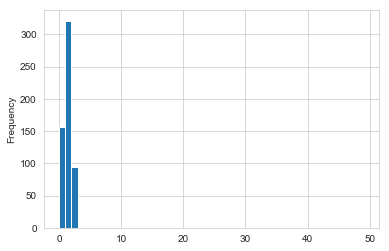

In [31]:
df_combined[df_combined.Type == 'Unknown']['Duration [µs]'].plot.hist(bins=range(0, 50, 1));

Looking at a longer sample, we find that the unknown pulses are indeed in locations where we would expect pulses from the laser sweeps. There are, however, also locations where sweeps are entirely missing.

In [32]:
df_combined.loc[df_combined.Type != '-']

,Time [s],Level,Duration [s],Duration [µs],Type,OOTX Name,OOTX Skip,OOTX Data,OOTX Axis
1,0.000000,1,7.458333e-05,74.583333,OOTX,j-1,False,1.0,0.0
3,0.000419,1,1.110417e-04,111.041667,OOTX,k-2,True,0.0,1.0
5,0.003090,1,1.416667e-05,14.166667,Pulse,NaN,NaN,NaN,NaN
7,0.008333,1,1.065000e-04,106.500000,OOTX,k-2,True,0.0,1.0
9,0.008752,1,5.866667e-05,58.666667,OOTX,j-0,False,0.0,0.0
11,0.013499,1,1.625000e-06,1.625000,Unknown,NaN,NaN,NaN,NaN
13,0.016668,1,1.369167e-04,136.916667,OOTX,NaN,NaN,NaN,NaN
15,0.017087,1,8.916667e-05,89.166667,OOTX,k-1,False,1.0,1.0
17,0.021529,1,1.416667e-06,1.416667,Unknown,NaN,NaN,NaN,NaN
19,0.025002,1,8.495833e-05,84.958333,OOTX,k-1,False,1.0,1.0


In [33]:
df_combined.loc[df_combined.Type == 'OOTX', 'OOTX Data'].dropna().astype('int64')

1       1
3       0
7       0
9       0
15      1
19      1
21      1
25      0
27      0
31      1
33      1
37      1
39      0
43      0
45      0
49      1
51      0
55      0
57      0
61      1
63      0
67      0
69      0
73      1
75      1
79      0
81      0
87      1
91      1
93      0
       ..
7053    1
7057    1
7059    1
7063    1
7067    0
7069    1
7073    0
7075    0
7079    1
7081    1
7085    1
7087    1
7091    1
7093    0
7097    0
7099    0
7103    0
7105    1
7109    1
7111    0
7115    1
7117    1
7121    1
7123    1
7127    1
7129    0
7131    1
7133    0
7137    0
7139    0
Name: OOTX Data, Length: 2285, dtype: int64

In [34]:
J_AXIS_FREQ = 60 # Hz
STATION_FREQ = J_AXIS_FREQ / 2